# Data Loading and Plotting example

In [2]:
%matplotlib inline
import numpy
import matplotlib
import sys 

sys.path.insert(0,'..')
from utils import plot_stroke

In [3]:
strokes = numpy.load('../data/strokes-py3.npy', allow_pickle=True)
with open('../data/sentences.txt') as f:
    texts = f.readlines()

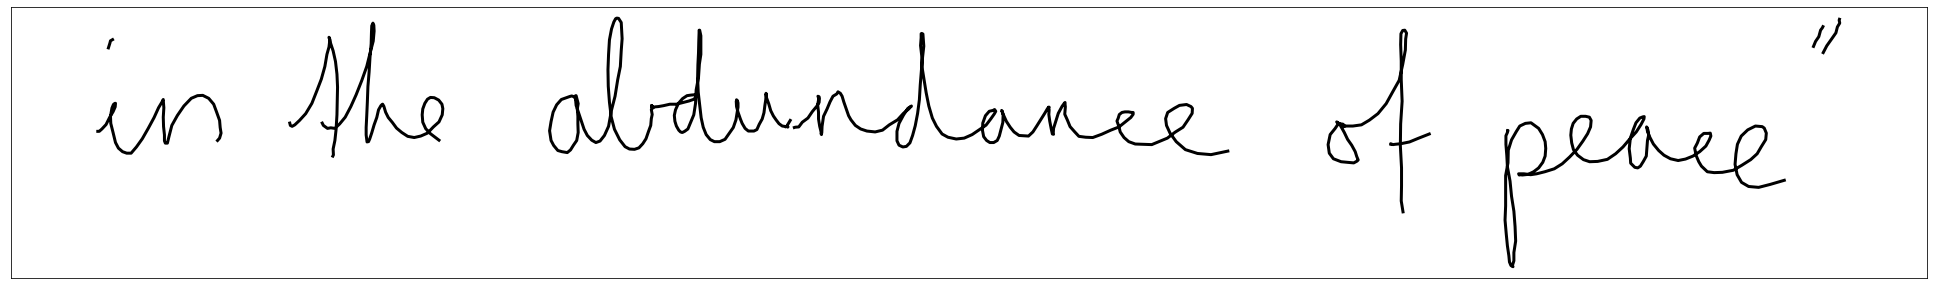

TEXT: in the abundance of peace"



In [4]:
idx = 0
stroke = strokes[idx]
text = texts[idx]
plot_stroke(stroke)
print('TEXT:', text)

### Strokes

Each handwritten sentence is represented as a 2D array with T rows and 3 columns. T is the number of timesteps. The first column represents whether to interrumpt the current stroke (i.e. when the pen is lifted off the paper). The second and third columns represent the relative coordinates of the new point with respect to the last point. Please have a look at the plot_stroke if you want to understand how to plot this sequence.

In [5]:
stroke

array([[ 0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.25,  0.  ],
       ...,
       [ 0.  , -0.85, -1.2 ],
       [ 0.  , -0.6 , -1.15],
       [ 1.  , -0.8 , -0.8 ]], dtype=float32)

### Data insight

In [6]:
import numpy as np

stroke_lengths = [len(stroke) for stroke in strokes]
print("Shortest stroke : %s, average stroke : %s, longest stroke : %s" % (min(stroke_lengths), int(np.mean(stroke_lengths)), max(stroke_lengths)))

text_lengths = [len(text) for text in texts]
print("Shortest text : %s, average text : %s, longest text : %s" % (min(text_lengths), int(np.mean(text_lengths)), max(text_lengths)))

end_stroke_val = np.unique([stroke[:][0] for stroke in strokes])
x_vals = [vals[1] for vals in stroke for stroke in strokes]
y_vals = [vals[2] for vals in stroke for stroke in strokes]

print("end stroke values are :", end_stroke_val)
print("X stroke values go from %s to %s" % (min(x_vals), max(x_vals)))
print("Y stroke values go from %s to %s" % (min(y_vals), max(y_vals)))

Shortest stroke : 301, average stroke : 644, longest stroke : 1191
Shortest text : 9, average text : 30, longest text : 65
end stroke values are : [0. 1.]
X stroke values go from -17.550001 to 31.0
Y stroke values go from -12.150001 to 25.050001


### Task 1 : unconditional generation

Here we will try to use a standard RNN generation methode were we train the network to guess the next value of the stroke sequence.
Considering that the average sentence is 30 caracters long and the average stroke is 600 time steps, the average stroke length for a caracter is about 20 time steps. Thus we want to chop the initial stroke data into 40 time steps chunks so there is always at least 1 caracter in the sequence.

In [8]:
from sklearn.model_selection import train_test_split
from numpy import save

seq_len = 40

X_raw = []
y_raw = []

for stroke in strokes:
    i = 0
    while i+seq_len < len(stroke):
        X_raw.append(stroke[i:i+seq_len])
        y_raw.append(stroke[i+seq_len])
        i += 1

X_raw = np.array(X_raw)
y_raw = np.array(y_raw)

X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, random_state=42)

save('../data/X_train.npy', X_train)
save('../data/X_test.npy', X_test)
save('../data/y_train.npy', y_train)
save('../data/y_test.npy', y_test)

print("training set shape : ", X_train.shape)
print("training goals shape : ", y_train.shape)
print("testing set shape : ", X_test.shape)
print("testing goals shape : ", y_test.shape)

training set shape :  (2718934, 40, 3)
training goals shape :  (2718934, 3)
testing set shape :  (906312, 40, 3)
testing goals shape :  (906312, 3)


A couple plots of the straining data :


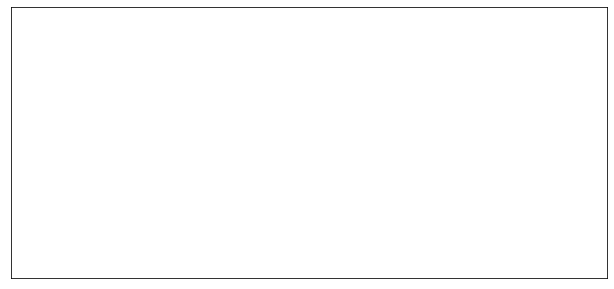

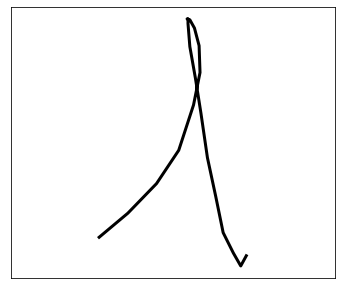

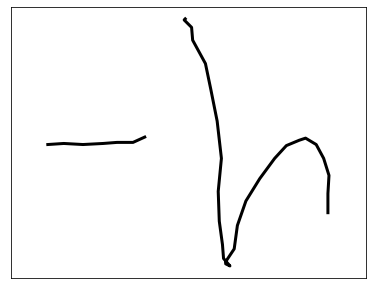

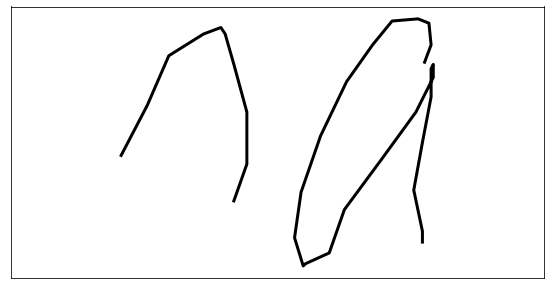

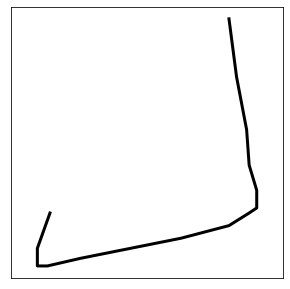

In [19]:
import random as rd

print("A couple plots of the straining data :")

for k in range(5):
    plot_stroke(X_raw[rd.randint(0, len(X_raw))])

As this new data set is very large I will only use a subset of it to train and evaluate my model

In [16]:
X_train_tiny = X_train[:100000]
y_train_tiny = y_train[:100000]

X_test_tiny = X_test[:10000]
y_test_tiny = y_test[:10000]

In [17]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1], activation='relu'))  #we use relu activation as the stroke aren't normalized
model.compile(loss='mse', optimizer='adam')

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 256)               266240    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 771       
Total params: 267,011
Trainable params: 267,011
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.fit(X_train_tiny, y_train_tiny, batch_size=128, epochs=20, validation_split=0.1, verbose=1)
model.save('../models/unconditional_generation_model.h5')

Train on 90000 samples, validate on 10000 samples
Epoch 1/20
90000/90000 [==============================] - 450s 5ms/step - loss: 1.8868 - val_loss: 1.5006
Epoch 2/20
90000/90000 [==============================] - 442s 5ms/step - loss: 1.5041 - val_loss: 1.4227
Epoch 3/20
90000/90000 [==============================] - 434s 5ms/step - loss: 1.4353 - val_loss: 1.3715
Epoch 4/20
90000/90000 [==============================] - 433s 5ms/step - loss: 1.3749 - val_loss: 1.3024
Epoch 5/20
90000/90000 [==============================] - 436s 5ms/step - loss: 1.3482 - val_loss: 1.2860
Epoch 6/20
90000/90000 [==============================] - 435s 5ms/step - loss: 1.3107 - val_loss: 1.2840
Epoch 7/20
90000/90000 [==============================] - 433s 5ms/step - loss: 1.2790 - val_loss: 1.2824
Epoch 8/20
90000/90000 [==============================] - 435s 5ms/step - loss: 1.2458 - val_loss: 1.3268
Epoch 9/20
90000/90000 [==============================] - 437s 5ms/step - loss: 1.2470 - val_loss: 1.2

Now that we trained our model we need to see if it learned to generate coherent hand writting. To do this we will choose a random sample from the testing data that will be the seed of the generated sequence. Then we will generate a stroke of a designated length step by step by adding the predicted step to the end of the "seed" and deleting the first time step like in a first in last out queue.

To make the generated string more realistique we will start the generated string  after the first pen lift generated and end it at the first pen lift after the designated length is reached.

note that we will need to turn the determine if there is a pen lift based on the model prediction with some kind on threshold function that will probably quite impactfull on the final result.

In [6]:
import numpy as np
import random as rd
from keras.models import load_model

seeds = np.load('../data/X_test.npy', allow_pickle=True)
saved_model = load_model('../models/unconditional_generation_model.h5')

for k in range(5):
    gen_len = 400 + rd.randint(0, 50)
    gen_stroke = []
    
    gen_buffer = seeds[rd.randint(0, len(seeds))]
    
    threshold = 0.5 + k/30
    
    print("Threshold : ", threshold)
    
    start_gen = 0
    i = 0
    
#     while start_gen == 0 and i <1000:
#         new_step = saved_model.predict(np.array([gen_buffer]))
#         print(new_step[0][0])
#         if new_step[0][0] >= threshold :
#             new_step[0][0] = 1
#             start_gen = 1
#         else :
#             new_step[0][0] = 0
#         gen_buffer = gen_buffer[1:]
#         gen_buffer = np.append(gen_buffer, new_step, axis=0)
#         i+=1
    
    stop_gen = 0
    i=0
    while i <gen_len:
        new_step = saved_model.predict(np.array([gen_buffer]))
        if new_step[0][0] >= threshold :
            new_step[0][0] = 1
            if i >= gen_len:
                stop_gen = 1
        else :
            new_step[0][0] = 0
        gen_buffer = gen_buffer[1:]
        gen_buffer = np.append(gen_buffer, new_step, axis=0)
        gen_stroke.append(new_step[0])
        i+=1
    gen_stroke = np.array(gen_stroke)
    print(gen_stroke)
#     plot_stroke(gen_stroke)

Threshold :  0.5
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Threshold :  0.5333333333333333
[[0.        0.        3.88089  ]
 [0.        0.        0.3427406]
 [0.        0.        0.       ]
 ...
 [0.        0.        0.       ]
 [0.        0.        0.       ]
 [0.        0.        0.       ]]
Threshold :  0.5666666666666667
[[0.         0.         0.42556214]
 [0.         0.         0.8174621 ]
 [0.         0.         1.1515957 ]
 ...
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
Threshold :  0.6
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Threshold :  0.6333333333333333
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


The model converges to 0, this might be due to the fact that the "pen rise" value is constant for any input. We can try to symulate it following a bernoulli porbability distribution based on the average amount ou ones in the data.

In [2]:
import numpy

X_train = numpy.load('../data/X_train.npy', allow_pickle=True)

p = 0
for x in X_train:
    if x[0][0] == 1:
        p+=1
p /= len(X_train)

print(p)

0.038509945441853315


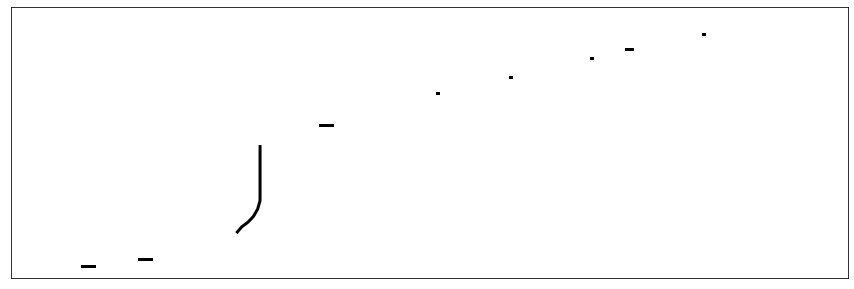

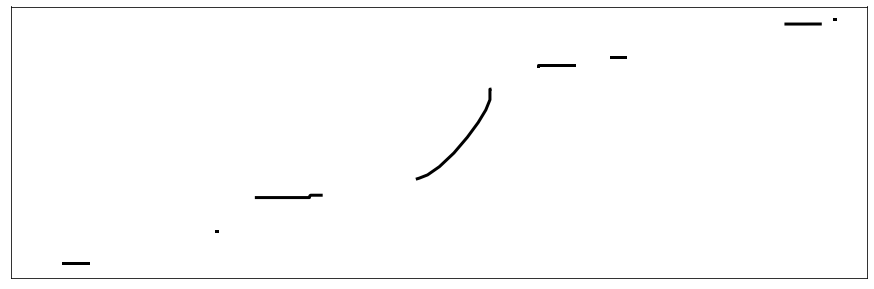

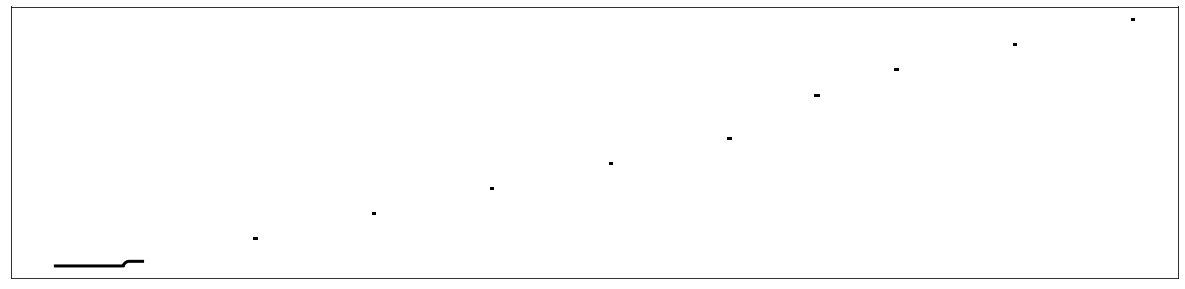

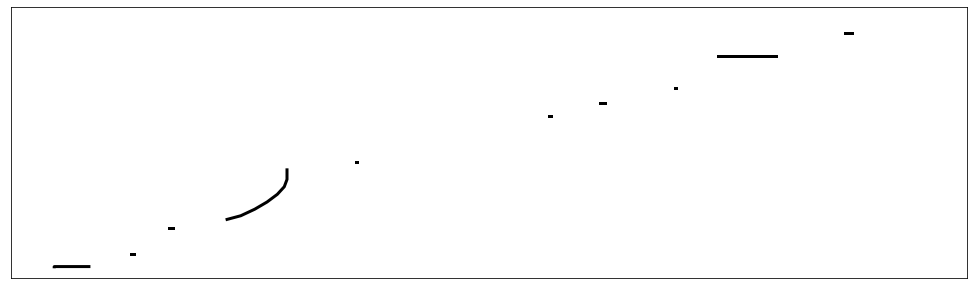

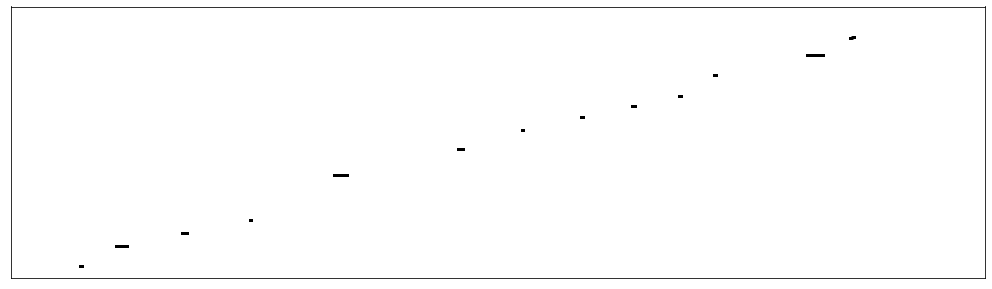

In [7]:
from keras.models import load_model
from utils import plot_stroke
import random as rd
import numpy as np

seeds = np.load('../data/X_test.npy', allow_pickle=True)
saved_model = load_model('../models/unconditional_generation_model.h5')

p = 0.038509945441853315

for k in range(5):
    gen_len = 400 + rd.randint(0, 50)
    gen_stroke = []
    
    gen_buffer = seeds[rd.randint(0, len(seeds))]
    
    start_gen = 0
    i = 0
    
    while start_gen == 0 and i <1000:
        new_step = saved_model.predict(np.array([gen_buffer]))
        if rd.random() <= p :
            new_step[0][0] = 1
            start_gen = 1
        else :
            new_step[0][0] = 0
        gen_buffer = gen_buffer[1:]
        gen_buffer = np.append(gen_buffer, new_step, axis=0)
        i+=1
    
    stop_gen = 0
    i=0
    while i <gen_len:
        new_step = saved_model.predict(np.array([gen_buffer]))
        if rd.random() <= p :
            new_step[0][0] = 1
            if i >= gen_len:
                stop_gen = 1
        else :
            new_step[0][0] = 0
        gen_buffer = gen_buffer[1:]
        gen_buffer = np.append(gen_buffer, new_step, axis=0)
        gen_stroke.append(new_step[0])
        i+=1
    gen_stroke = np.array(gen_stroke)
#     print(gen_stroke)
    plot_stroke(gen_stroke)

Well some segments seem like they could be hand drawn but most of them are just horizontal segments. Lets try to separate the end stroke output and coordinates outputs having a binary cross-entropy loss for the first and a mean squared logarithmic error for the second.

In [29]:
import numpy as np
from numpy import load, save

y_train = load('../data/y_train.npy', allow_pickle=True)
y_test = load('../data/y_test.npy', allow_pickle=True)

y_train_e = []
y_train_coord = []

for y in y_train:
    y_train_e.append(y[0])
    y_train_coord.append(y[1:])
    
y_train_e = np.array(y_train_e)
y_train_coord = np.array(y_train_coord)
save('../data/y_train_e.npy', y_train_e)
save('../data/y_train_coord.npy', y_train_coord)



y_train_reshaped = [y_train_e, y_train_coord]

print(y_train_reshaped[0].shape, y_train_reshaped[1].shape)
    
y_test_e = []
y_test_coord = []

for y in y_test:
    y_test_e.append(y[0])
    y_test_coord.append(y[1:])
    
y_test_e = np.array(y_test_e)
y_test_coord = np.array(y_test_coord)
save('../data/y_test_e.npy', y_test_e)
save('../data/y_test_coord.npy', y_test_coord)

y_test_reshaped = [y_test_e, y_test_coord]

print(y_test_reshaped[0].shape, y_test_reshaped[1].shape)

(2718934,) (2718934, 2)
(906312,) (906312, 2)


In [38]:
import numpy as np
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input
from keras.losses import mean_squared_logarithmic_error

# X_train = np.load('../data/X_train.npy', allow_pickle=True)[:100000]
# y_train_e = np.load('../data/y_train_e.npy', allow_pickle=True)[:100000]
# y_train_coord = np.load('../data/y_train_coord.npy', allow_pickle=True)[:100000]
# y_train = [y_train_e, y_train_coord]

model_in= Input(shape=(X_train.shape[1], X_train.shape[2]))

RNN = LSTM(900)(model_in)
RNN = Dropout(0.1)(RNN)

end_strok_out = Dense(1,  activation='softmax')(RNN)
coord_out = Dense(2,  activation='linear')(RNN)


model = Model(inputs=model_in, outputs=[end_strok_out, coord_out])
model.compile(optimizer = 'adam', loss = ['binary_crossentropy', 'mean_squared_logarithmic_error'])

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 40, 3)        0                                            
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 900)          3254400     input_8[0][0]                    
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 900)          0           lstm_8[0][0]                     
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 1)            901         dropout_6[0][0]                  
____________________________________________________________________________________________

In [ ]:
model.fit(X_train, y_train, epochs=5, validation_split=0.1, verbose=1)
model.save('../models/unconditional_generation_model_double_output.h5')

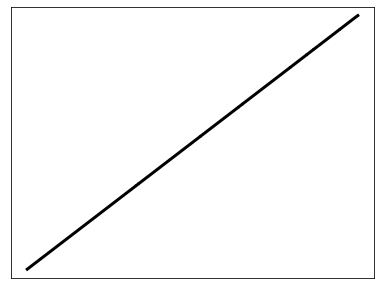

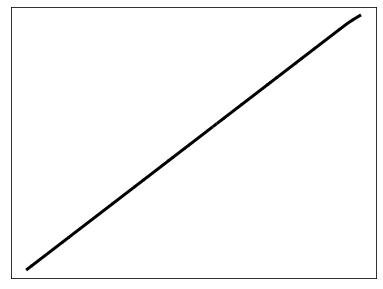

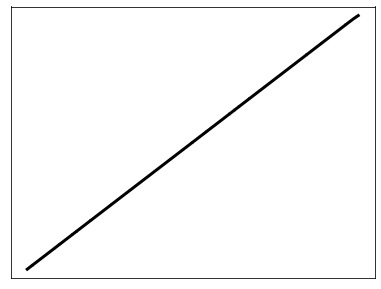

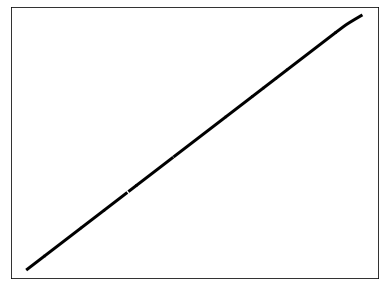

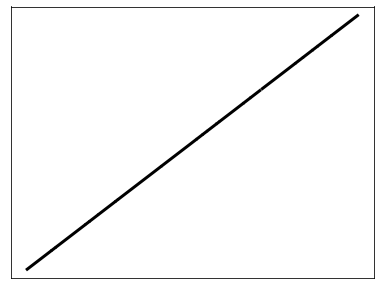

In [11]:
from keras.models import load_model
from utils import plot_stroke
import random as rd
import numpy as np

seeds = np.load('../data/X_test.npy', allow_pickle=True)
saved_model = load_model('../models/unconditional_generation_model_double_output.h5')

p = 0.038509945441853315

for k in range(5):
    gen_len = 400 + rd.randint(0, 50)
    gen_stroke = []
    
    gen_buffer = seeds[rd.randint(0, len(seeds))]
    
    start_gen = 0
    i = 0
    
    while start_gen == 0 and i <1000:
        new_step = saved_model.predict(np.array([gen_buffer]))
        if rd.random() <= p :
            new_step[0][0][0] = 1
            start_gen = 1
        else :
            new_step[0][0][0] = 0
        new_step = np.array([new_step[0][0][0], new_step[1][0][0], new_step[1][0][1]])
        new_step = np.reshape(new_step, newshape=(1, 3))
        gen_buffer = gen_buffer[1:]
        gen_buffer = np.append(gen_buffer, new_step, axis=0)
        i+=1
    
    stop_gen = 0
    i=0
    while i <gen_len:
        new_step = saved_model.predict(np.array([gen_buffer]))
        if rd.random() <= p :
            new_step[0][0][0] = 1
            if i >= gen_len:
                stop_gen = 1
        else :
            new_step[0][0][0] = 0
        new_step = np.array([new_step[0][0][0], new_step[1][0][0], new_step[1][0][1]])
        new_step = np.reshape(new_step, newshape=(1, 3))
        gen_buffer = gen_buffer[1:]
        gen_buffer = np.append(gen_buffer, new_step, axis=0)
        gen_stroke.append(new_step[0])
        i+=1
    gen_stroke = np.array(gen_stroke)
#     print(gen_stroke)
    plot_stroke(gen_stroke)

### Alex Graves approche 

Here we are going to build and train a mixture density network wich uses the outputs of a recurrent network as parameters for a probability density. First we need to mormalize the data

In [5]:
from sklearn.preprocessing import normalize
from numpy import save, load, concatenate

X_raw = load('../data/strokes-py3.npy', allow_pickle=True)

X_end_strok = []
X_x = []
X_y = []
for k in range(len(X_raw)):
    X_end_strok.append(np.array([X[0] for X in X_raw[k]]))
    X_x.append(np.array([X[1] for X in X_raw[k]]))
    X_y.append(np.array([X[2] for X in X_raw[k]]))
    
X_end_strok = np.array(X_end_strok)
X_end_strok.reshape((-1,1))
print(X_end_strok.shape)

X_x = np.array(X_x)
X_x.reshape((-1,1))
print(X_x.shape)


X_y = np.array(X_y)
X_y.reshape((-1,1))
print(X_y.shape)

X_x_normalized = []
X_y_normalized = []

for i in range(len(X_x)):
    X_x_normalized.append(normalize(X_x[i], norm='l2'))
    X_y_normalized.append(normalize(X_y[i], norm='l2'))

X_x_normalized = np.array(X_x_normalized)
X_y_normalized = np.array(X_y_normalized)    

print(X_x_normalized.shape)
print(X_y_normalized.shape)

X_normalized =[]
for i in range(len(X_x)):
    X_normalized.appen(concatenate((X_end_stroke[i], X_x_normalized[i], X_y_normalized[i]), axis=1))

X_normalized = np.array(X_normalized)

save('../data/strokes_normalized.npy', X_normalized)

(6000,)
(6000,)
(6000,)


ValueError: Expected 2D array, got 1D array instead:
array=[  0.           0.           0.25         0.45000002   0.7
   0.6          0.6          0.35         0.05        -0.1
  -0.25        -0.25        -0.25         0.05         0.4
   0.4          0.5          0.7          0.7          0.75
   0.90000004   1.           1.           1.           0.75
   0.6          0.2          0.           0.           0.1
  -0.1          0.05         0.15         0.           0.15
   0.1          0.25         0.25         0.5          0.95
   1.1          1.25         1.0500001    0.90000004   1.
   0.85         0.5          0.5          0.1          0.15
  -0.25        -0.35        -0.25       -17.550001    -0.35
  -0.1         -0.25        -0.25        31.           0.1
   0.3          0.45000002   0.8          1.0500001    1.0500001
   0.85         0.75         0.6          0.35         0.35
   0.1          0.          -0.1          0.15         0.1
   0.45000002   0.4          0.25         0.1         -0.05
  -0.05        -0.15        -0.2         -0.3          0.05
  -0.1          0.25        -2.05         0.2          0.7
   0.55         0.7          0.8          0.95         0.95
   0.90000004   0.95         0.85         0.6          0.5
   0.15        -0.05        -0.15        -0.1         -0.1
  -0.05        -0.05        -0.2         -0.15        -0.2
  -0.1         -0.1         -0.1          0.           0.15
   0.1          0.15         0.2          0.35         0.4
   0.45000002   0.3          0.4          0.25         0.05
   0.2          0.3          0.45000002   0.7          0.7
   0.90000004   1.           1.1          1.1          1.15
   1.           0.95         0.55         0.1         -0.15
  -0.55        -0.75        -0.65000004  -0.5         -0.45000002
  -0.35        -0.1          0.1          0.5          0.8
   1.45         1.65        21.45        -0.1          0.
  -0.2         -0.3         -0.35        -0.55        -0.85
  -0.8         -0.6         -0.35        -0.25         0.25
   0.45000002   0.7          0.7          0.90000004   0.55
   0.5          0.55         0.25        -0.05         0.
  -0.1          0.15        -0.25        -0.1         -0.05
  -0.1          0.05         0.1          0.45000002   0.45000002
   0.45000002   0.55         0.75         0.7          0.7
   0.75         0.7          0.5          0.6          0.45000002
   0.45000002   0.15         0.15        -0.1         -0.05
  -0.45000002  -0.3         -0.2         -0.3         -0.4
  -0.35        -0.15        -0.1          0.05         0.2
   0.3          0.55         0.90000004   0.90000004   0.75
   0.85         0.75         0.65000004   0.55         0.45000002
   0.35         0.1          0.15        -0.15         0.15
   0.          -0.05         0.05        -0.1          0.05
   0.           0.1          0.15         0.25         0.6
   0.85         1.1          1.1          1.15         1.
   0.85         0.3          0.15        -0.15        -0.25
  -0.55        -0.7         -0.75        -0.7         -0.5
  -0.2          0.1          0.25         0.4          0.3
   0.3          0.4          0.55         0.45000002   0.55
   0.3          0.1          0.4          0.15         0.25
   0.           0.          -0.15        -0.05        -0.1
   0.          -0.05        -0.05        -0.1         -0.05
   0.1          0.25         0.25         0.35         0.5
   0.7          0.7          0.90000004   0.90000004   0.7
   0.7          0.45000002   0.2          0.15         0.
  -0.1         -0.15         0.05        -0.1          0.05
   0.25         0.4          0.3          0.5          0.55
   0.4          0.55         0.5          0.4          0.5
   0.3          0.15         0.15         0.05         0.
   0.           0.05        -0.05         0.1          0.35
   0.35         0.45000002   0.45000002   0.5          0.55
   0.35         0.25         0.15         0.05         0.15
  -0.15         0.1          0.45000002   0.65000004   0.05
   0.15         0.6          0.6          0.95         0.75
   0.75         0.4          0.05        -0.05        -0.2
   0.1          0.          -0.15         0.15         0.
   0.2          0.2          0.1          0.          -0.05
   0.1          0.05         0.25         0.6          0.5
   0.5          0.65000004   0.2          0.4          0.3
   0.3          0.4          0.4          0.4          0.75
   0.90000004   1.0500001    1.4          1.25         1.15
   1.4          1.           0.90000004   0.4          0.05
  -0.05        -0.55        -0.75        -0.75        -0.35
   0.           0.35         0.65000004   0.6          0.6
   0.45000002   0.45000002   0.4          0.3          0.15
   0.2          0.2          0.2         -0.1         -0.05
  -0.2         -0.1          0.          -0.1          0.2
   0.05         0.35         0.35         0.45000002   0.6
   0.7          0.95         1.           1.4          1.35
   1.35         1.25         1.1          0.8          0.6
   0.25        -0.2         -0.25        -0.65000004  -0.65000004
  -0.45000002  -0.05         0.2          0.5          0.55
   0.65000004   0.6          0.35         0.3          0.3
   0.05        -0.15        -0.1          0.05         0.
   0.25         0.5          0.65000004   0.65000004   0.85
   1.6          0.75         0.65000004   1.35         0.5
   0.25        -0.1          0.1         -0.05         0.15
   0.25         0.15         0.05         0.2         -0.05
   0.05         0.4          0.4          0.65000004   0.4
   0.1          0.           0.05        -0.1          0.45000002
   0.45000002   0.8          0.7          1.15         1.2
   1.5          1.5500001    1.4          1.0500001    0.95
   0.4          0.          -0.25        -0.55        -0.6
  -0.5         -0.45000002  -0.2         -0.2          0.35
   0.2          0.65000004   0.8          1.1          1.3000001
   1.5          2.65         1.3000001    1.35         0.85
   0.7          0.05        -0.25        -0.75        -1.2
  -0.90000004  -1.1         -0.35         0.15         0.6
   1.0500001    1.5500001    2.05         2.3          2.8500001
   2.9         16.85        -0.1         -0.1         -0.25
  -0.6         -0.5         -0.85        -0.35         0.2
   0.7          1.3000001    1.0500001    1.1          0.55
   0.2         -0.25        -0.25        -0.6         -0.7
  -0.55        -0.5         -0.2         -0.3         -0.3
   0.           0.15         0.55         0.90000004   1.15
   1.45         1.35         1.45         1.4          1.0500001
   1.15         0.6          0.45000002   0.05         0.15
  -0.3         -0.35        -0.3         -0.05         0.1
   0.           0.15        -0.25        -0.05         0.2
   0.          -0.05         0.3         -0.05        -2.05
   0.           0.4          0.35         0.95         1.5
   1.45         1.9          2.15        11.150001     0.
   0.05        -0.1         -0.25         0.           0.15
   0.1          0.45000002   0.25         0.4          0.2
   0.1         -0.3          0.          -0.25         0.1
  -0.35        -0.25        -0.1         -0.25        -0.2
  -0.2          0.1          0.           0.           0.4
   0.05         0.55         0.8          0.6          0.95
   0.95         1.3000001    0.65000004   0.45000002   0.1
  -0.1         -0.4         -0.7         -0.85        -0.95
  -0.95        -0.5         -0.05        -0.1          0.25
   0.65000004   1.15         1.           1.4          1.6
   1.35         1.25         1.25         1.           0.8
   0.5          0.1         -0.3         -0.65000004  -0.8
  -0.7         -0.6         -0.3         -0.1          0.15
   0.3          0.7          1.           1.0500001    1.35
   1.65         1.4          1.25         1.15         1.1
   0.8          0.5          0.05        -0.25        -0.5
  -0.65000004  -0.45000002  -0.5         -0.2          0.2
   0.05         0.7          0.5          0.45000002   0.5
   0.5          0.1          0.1          0.2         -0.1
  -0.15        -0.1          0.           0.05         0.1
   0.4          0.6          0.90000004   0.90000004   1.1
   1.3000001    1.25         1.25         1.15         1.0500001
   0.55         0.3         -0.1         -0.35        -0.75
  -0.7         -0.4         -0.45000002   0.25         0.45000002
   0.45000002   1.           1.15         1.4          1.85
   1.45         1.5          1.1          0.7          0.75
   0.1         -0.35        -0.35        -1.15        -1.3000001
  -1.1         -0.65000004  -0.25        -0.15         0.35
   0.75         1.2          1.7          1.95         2.4
   2.1000001    4.4500003    0.           0.          -0.1
  -0.3         -0.3         -0.55        -0.35        -0.15
   4.55        -0.05         0.1         -0.4         -0.25
  -0.7         -0.85        -0.6         -0.8       ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [7]:
import numpy as np
import tensorflow as tf
import keras.backend as K
from numpy.random import multivariate_normal
from numpy.random import binomial
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Lambda

tf.compat.v1.enable_eager_execution()


X_train = np.load('../data/X_train.npy', allow_pickle=True)
X_train_tiny = X_train[:100000]
y_train = np.load('../data/y_train.npy', allow_pickle=True)
y_train_tiny = y_train[:100000]

def softmax(X):
    sm = []
    for k in range(len(X)):
        sm.append(np.exp(X[k])/sum(np.exp(X)))
    return np.array(sm)

def mixture(param_tensor):
    param_tensor = K.eval(param_tensor)
    x = []
    y = []
    weights = []
    
    for k in range(10):
        weights.append(k)
        
        means = [K.eval(param_vec[k+1]), K.eval(param_vec[k+2])]
        means = np.array(means)
        
        devs = [np.exp(K.eval(param_vec[k+3])), np.exp(K.eval(param_vec[k+4]))]
        D = np.diag(devs)
        
        corr = [K.eval(np.tanh(param_vec[k+5+i])) for i in range(4)]
        corr = np.array(corr)
        corr = np.reshape(corr, (2,2))
        
        cov = D*corr*D
        
        coord = multivariate_normal(means, cov)
        x.append(coord[0])
        y.append(coord[1])
    
    weights = softmax(weights)
    
    e = binomial(1, 1/(1+np.exp(param_vec[-1])))
    X = 0
    Y = 0
    
    for k in ragne(len(weights)):
        X += weights[k]*x[k]
        Y += weights[k]*y[k]
    
    return np.array([e, X, Y])
    

model = Sequential()
model.add(LSTM(900, input_shape=(X_train_tiny.shape[1], X_train_tiny.shape[2])))
model.add(Dense(121, activation='tanh'))
model.add(Lambda(mixture, output_shape=[3]))
model.compile(loss='categorical_crossentropy', optimizer='adam', metric=['accuracy'])

model.summary()

True
True


AttributeError: 'Tensor' object has no attribute '_numpy'